In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import histlite as hl
import csky as cy
import pandas as pd

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
from scipy import stats
#making healpy maps
import h5py as h5
import healpy as hp
import os

In [2]:
import setup
import chime_localizations as loc

Setting up Analysis for:
GFU_for_2011_2012_2013_2014_2015_2016_2017_2018_2019
Setting up GFU_for_2011_2012_2013_2014_2015_2016_2017_2018_2019...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2011_MC.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2012_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2013_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2014_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2015_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2016_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2017_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2018_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2019_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/GRL/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/GRL/IC86_2012_data.npy ...
Reading /

In [3]:
mpl.rcParams['font.size'] = 20
ana=cy.CONF['ana']

seed=1
new_nside=1024

In [4]:
frbs=setup.load_frbs(spatial_priors=True)
#spatial prior: use FRB20190416A, dec=33.3
wn=np.where(frbs['src']=='FRB20190416A')
wn=wn[0][0] #want only one of the bursts

frb_probs, msk=loc.make_healpix_map('FRB20190416A', new_nside=new_nside, max_cl=0.9997)

sum of map probabilities: 1.00000


In [5]:
src=setup.sources(20*84600., frbs['mjd'].values[wn], frbs['ra_deg'].values[wn], 
                  frbs['dec_deg'].values[wn])

##sp_tr used only for getting llh prior term!
sp_tr = cy.get_spatial_prior_trial_runner(src_tr=src, 
                        llh_priors=frb_probs, get_pixmask=True)

In [6]:
## scan sky, w/in 99.97% CL only - pixmask call
sstr = cy.get_sky_scan_trial_runner(ana=ana, nside=new_nside, 
            src_kw={'mjd':src['mjd'], 't_100':src['t_100'], 'sigma_t':0.}, 
            pixmask=msk)

%time scan = sstr.get_one_scan(seed = seed, mp_cpus=15, logging=True)

Scanning 812 locations using 15 cores:
        812/812 coordinates complete.   
CPU times: user 1.58 s, sys: 1.33 s, total: 2.91 s
Wall time: 4.92 s


In [63]:
#if len(np.where(scan[1]>0.)[0])==0: max_map=2. 
#else: max_map=max(scan[1])
#hp.mollview(scan[1], coord='C',rot=180, min=0., max=max_map)

In [108]:
import imp
imp.reload(setup)

<module 'setup' from '/home/jthwaites/FRB/setup.py'>

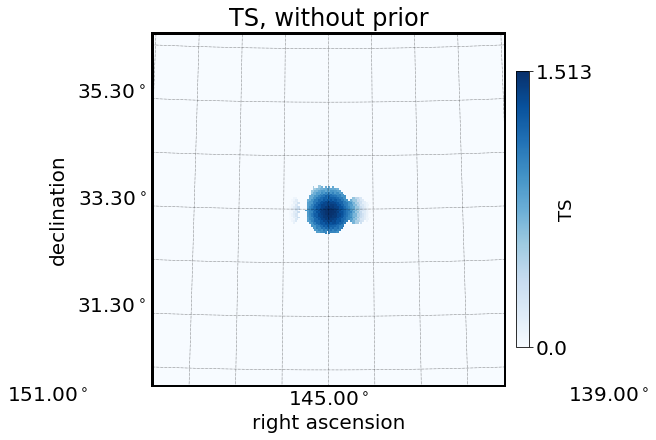

In [81]:
setup.plot_zoom(scan[1], src['ra'][0], src['dec'][0], contour_scan=False, 
                title='TS, without prior', 
                reso=2., col_label=r"TS")

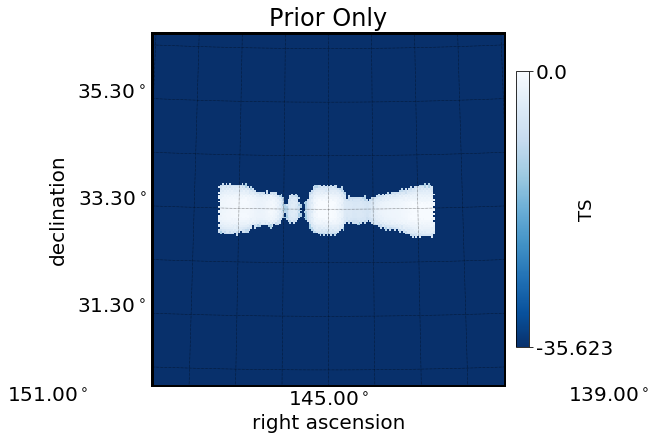

In [109]:
setup.plot_zoom(sp_tr.llh_prior_term[0], src['ra'][0], src['dec'][0], contour_scan=False, 
                title='Prior Only', 
                reso=2., col_label=r"TS")

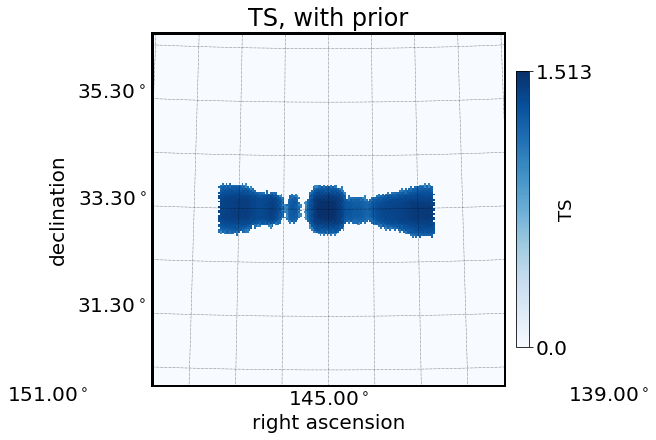

In [110]:
ts_with_prior = scan[1] + sp_tr.llh_prior_term[0]
setup.plot_zoom(ts_with_prior, src['ra'][0], src['dec'][0], contour_scan=False, 
                title='TS, with prior', 
                reso=2., col_label=r"TS")